<h1 style="font-size:3rem;color:orange;"> Pulsed Radar Simulation and Tutorial</h1>

[Ari Granevich](https://github.com/arigra)

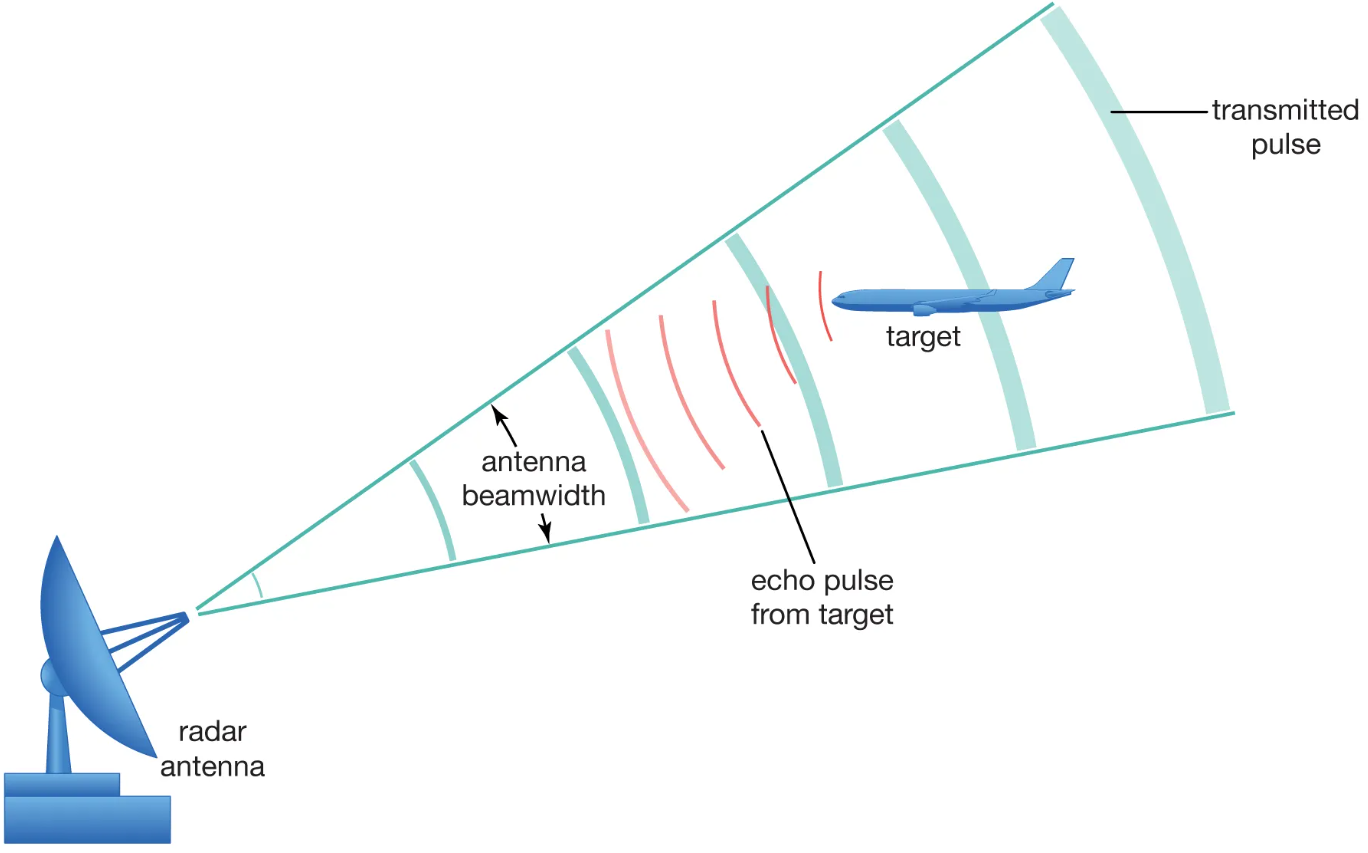

## Agenda
---

1. Transmitted Siganl
2. Targets Parameters
3. Recieved Signal
4. Processing
5. Interactive simulation
6. Dataset creation
* Bonus - torch dataset
* planned future work

## Imports

In [1]:
import os
import torch
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.fft import fft, fftshift
from scipy.signal import spectrogram, correlate
from ipywidgets import interact, widgets, Layout
from torch.utils.data import Dataset, DataLoader

## 1. Transmitted Signal
---

### Parameter definition


In order to create the signal that we will transmit, we first need to define the radar's paramaters.
These parameters are:
1. Carrier frequency
2. pulse time (width)
3. PRI - Pulse Repitition Interval
4. Bandwidth
5. Sampling frequency
6. Amplitude


### 1. Carrier Frequency


The carrier frequency is the frequency of the signal we send. 

This frequency is chosen to fit the specific needs of the radar, where higher frequencies provide better resolution but suffer more from attenuation.

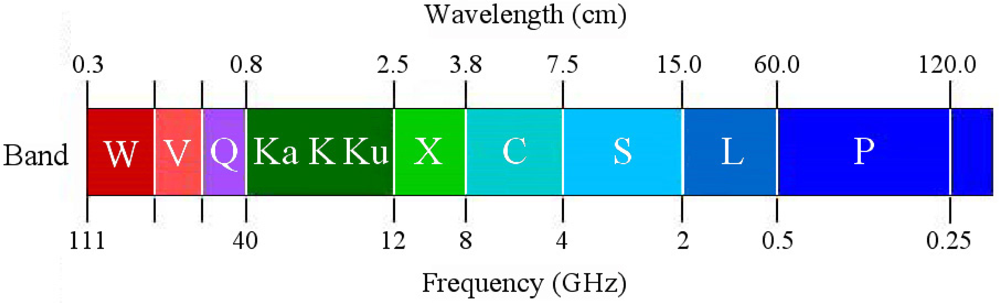

In [2]:
fc = 80e9 # carrier frequency in Hz.

### 2+3. Pulse Width and PRI

The working principle in a pulsed radar is to transmit a signal for a short duration and then stop to listen for the returning echoes.

Pulse width is the duration of each transmitted pulse, together with the listening time they make the PRI (Pulse repetition interval).

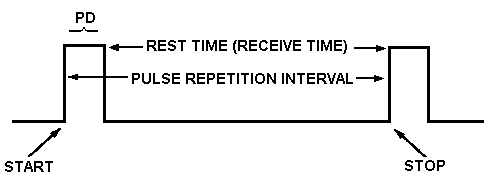

Longer pulses provide better Doppler resolution and shorter pulses provide better range resolution, so we need to consider this tradeoff when we choose the pulse width.

The listening time determines the maximum range to detect targets, this range is the time we listen, times the speed of light (at which the signal travels) divided by 2, because the signal has to travel to the target and back!

In this simulation we choose a pulse width of 1 micro second and a PRI of 10 micro seconds

so what is the max range for detection here?

(PRI-pulse width)*c/2 = (4e-6 * 3e8) / 2 = 600 meters!

In [3]:
pulse_width = 1e-6  # Pulse width in seconds
PRI = 5*pulse_width  # Pulse repetition interval in seconds

### 4+5. Bandwidth and sampling frequency

The bandwidth is the range of frequencies over which the radar signal is transmitted, the higher the bandwidth the better the range resolution gets.

The sampling frequency is how many samples we get every second. this frequency should be at least the nyquist frequency, which is 2 * Bandwidth - this is because we can only know the exact frequency without ambiguity in this frequency. An example, the green line is the original signal, the red line is what we interpret from the blue dots, which are the values we sample:

Sampling frequency = Bandwidth:

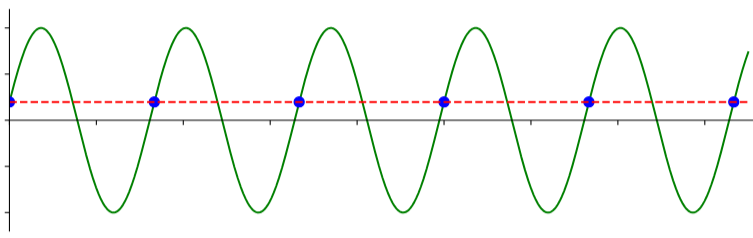

Sampling frequency = 1.2 * Bandwidth:

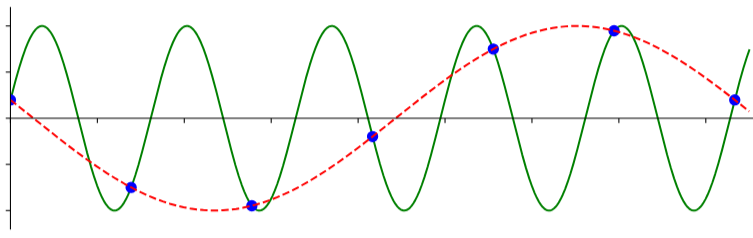

Sampling frequency = 1.5 *Bandwidth:

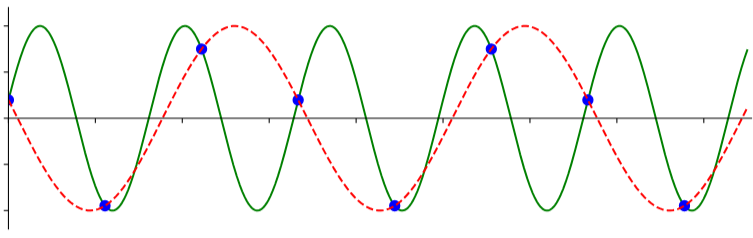

Sampling frequency = 2 * Bandwidth:

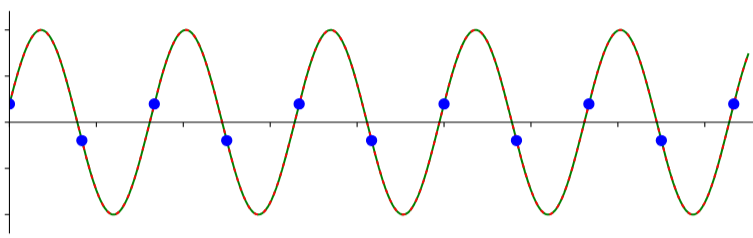

[source: pysdr](https://pysdr.org/content/sampling.html) 

In [4]:
B = 200e6  # Bandwidth of the chirp in Hz 
fs = 10*B  # Sampling frequency in Hz

### 6. Amplitude

The amplitude of the radar signal refers to the magnitude of the oscillating electric field in the transmitted wave. 

higher Amplitude gives better performance, but it has the hardware and regulatory limitation that needs to be considered.

In our simulation, we commonly define the amplitude to be 1

In [5]:
A = 1

### additional settings

here we define the time array, we also set an array of zeros in the signal size. we also define the slope.

In [6]:
num_pulses = 500 # Number of pulses to simulate
tot_time = num_pulses * PRI 
t = np.arange(0, tot_time - 1/fs , 1/fs) # we subtract 1/fs because we start at zero and not 1
chirp_signal = np.zeros_like(t, dtype=np.complex128)
slope = B / pulse_width  # Chirp rate

### Window function

When we use an FFT to measure the frequency components of our signal, the FFT assumes that it’s being given a piece of a periodic signal. It behaves as if the piece of signal we provided continues to repeat indefinitely. It’s as if the last sample of the slice connects back to the first sample. It stems from the theory behind the Fourier Transform.

The way we make up for this cyclic property is through “windowing”. We multiply the slice of signal by a window function, which is just any function that tapers to zero on both ends. (That means, X[0] and X[99] should be same or close)

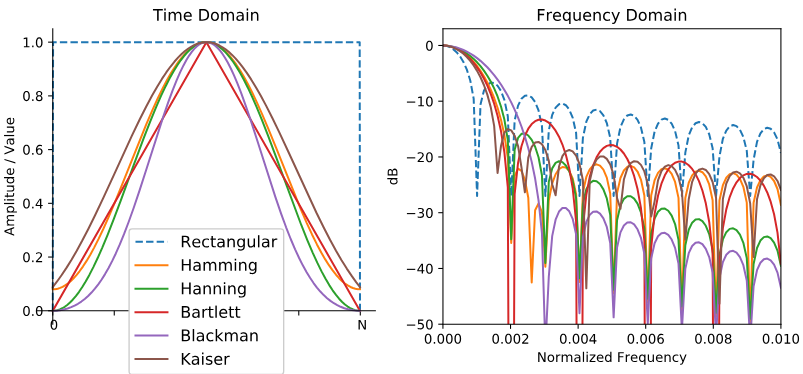

[source: pysdr](https://pysdr.org/content/sampling.html) 

In this simulation We choose to work with the hamming window function.

### 7.Creating the actual chirp signal

A chirp is a signal whose frequency changes linearly over time. The instantaneous frequency f(t) of a linear FM chirp is given by:
$$f(t) = f_0 +S\cdot t$$
Where S is thew slope, $f_0$ is the initial frequenc.

The phase is:
$$\phi (t) = \int{f(\tau)d\tau} = \int{(f_0 +S\cdot\tau)d\tau} = f_0 t +0.5 S\cdot t^2$$
complex exponential representation:

$$s(t) = Ae^{j2\pi \phi(t)} = Ae^{j2\pi(f_0 t +0.5 S\cdot t^2)}$$

assuming initial frequency is zero:

$${chirp}(t) = A \cdot e^{j 2\pi \left( \dfrac{1}{2} \cdot \text{slope} \cdot t_{\text{pulse}}^2 \right)}$$


In [7]:
window_length = int(pulse_width * fs) # this multiplication gives the number of samples in the pulse
for i in range(num_pulses):
    pulse_start = i * PRI
    pulse_end = pulse_start + pulse_width
    pulse_indices = (t >= pulse_start) & (t < pulse_end)
    current_window_length = np.sum(pulse_indices)  
    hamming_window = np.hamming(current_window_length)
    t_pulse = t[pulse_indices] - pulse_start  # Time relative to pulse start
    
    # This is the the actual signal, we use the window function on it and send it.
    chirp = A * np.exp(1j* 2 * np.pi * (0.5 * slope * t_pulse**2))
    chirp_windowed = chirp * hamming_window  # Apply Hamming window
    chirp_signal[pulse_indices] = chirp_windowed

### Visualize the entire signal, and a single pulse

/home/hawk/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hawk/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


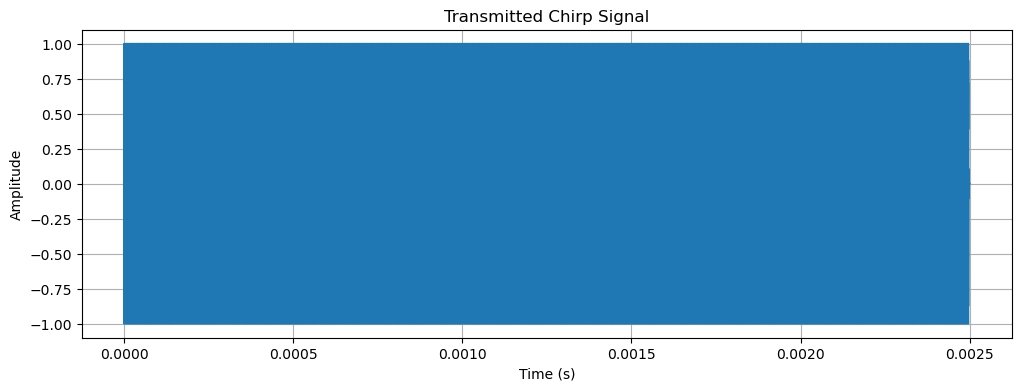

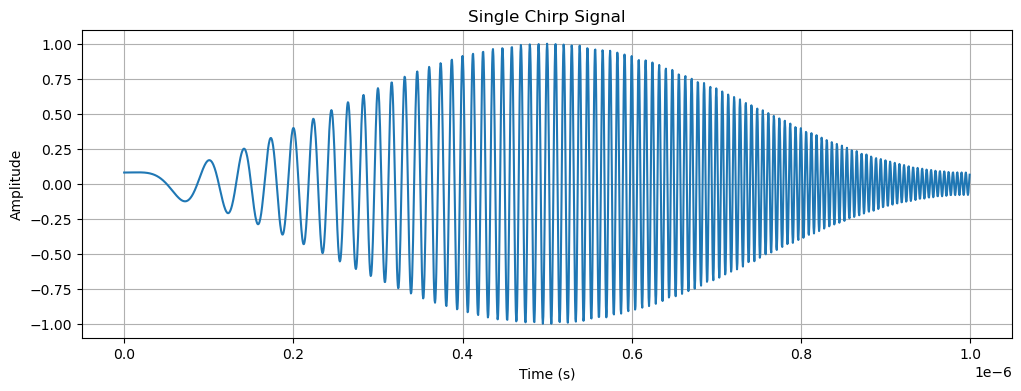

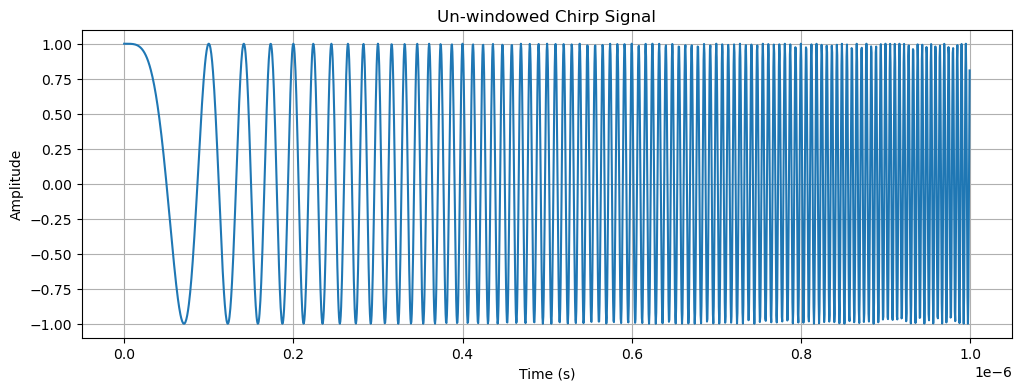

In [8]:
# Plot the chirp signal
plt.figure(figsize=(12, 4))
plt.plot(t, chirp_signal)
plt.title("Transmitted Chirp Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot the first pulse
plt.figure(figsize=(12, 4))
plt.plot(t_pulse, chirp_signal[pulse_indices])
plt.title("Single Chirp Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(t_pulse, chirp)
plt.title("Un-windowed Chirp Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## 2. Targets Parameters
---

In this part, We define the targets that our radar will discover!

Each target target needs to have its own range, velocity and RCS(Radar Cross Section).

we also get the time delays and Doppler shifts.

### basic definitions

In [9]:
c = 3e8  # Speed of light in m/s
PRF = 1 / PRI
max_range = c * (PRI - pulse_width) / 2
v_max = (c * PRF) / (4 * fc)
print(f'With the PRI: {(PRI)} and pulse width: {(pulse_width)}, the maximum range is {np.round(max_range)} meters and the maximum velocity is {np.round(v_max)} m/s.')

With the PRI: 4.9999999999999996e-06 and pulse width: 1e-06, the maximum range is 600.0 meters and the maximum velocity is 188.0 m/s.


In [10]:
num_targets = np.random.randint(1,8)
target_ranges = np.random.uniform(0, max_range, num_targets)
target_velocities = np.random.uniform(-v_max, v_max, num_targets)
target_rcs = np.random.uniform(0.5, 1, num_targets)

define the time delay and doppler shift (the doppler shift is the change in frequency that happens when hitting a moving target)

In [11]:
time_delays = 2 * target_ranges / c
doppler_shifts = -2 * target_velocities * fc / c

### print the targets properties

In [12]:
print(num_targets, 'targets')
print()
for i in range(num_targets):
    print(f"Target {i+1}:")
    print(f"  Range: {target_ranges[i]} meters")
    print(f"  Velocity: {target_velocities[i]} m/s")
    print(f"  RCS: {target_rcs[i]} m^2")
    print(f"  Time Delay: {time_delays[i]:.6e} seconds")
    print(f"  Doppler Shift: {doppler_shifts[i]:.2f} Hz")
    print()

2 targets

Target 1:
  Range: 284.2732326269873 meters
  Velocity: -42.97888179187103 m/s
  RCS: 0.6273639391818991 m^2
  Time Delay: 1.895155e-06 seconds
  Doppler Shift: 22922.07 Hz

Target 2:
  Range: 59.6564156425232 meters
  Velocity: 175.35527836763706 m/s
  RCS: 0.6644469895611294 m^2
  Time Delay: 3.977094e-07 seconds
  Doppler Shift: -93522.82 Hz



## 3. Recieved Signal
---

We first need to creat a np array for it, the same size as the sent chirp signal

In [13]:
received_signal = np.zeros_like(chirp_signal, dtype=np.complex128)

we now create the recieved signal, considering the effects that the targets have on the pulse we have sent.

In [14]:
# We refer to every pulse, therefore we check the start and end of each one.
for i in range(num_pulses):
    pulse_start = i * PRI
    pulse_end = pulse_start + pulse_width

    # now, for each target:
    for j in range(num_targets):
        # calculate the time delay
        total_time_delay = pulse_start + time_delays[j]
        t_delayed = t - total_time_delay
        valid_indices = (t >= total_time_delay) & (t < total_time_delay + pulse_width)
        t_valid = t_delayed[valid_indices]
        
        # skip if there is no echo 
        if len(t_valid) == 0:
            continue

        # generate the delayed chirp signal
        chirp_delayed = A * np.exp(1j * 2 * np.pi * (0.5 * slope * t_valid**2))
        # apply the doppler shift
        doppler_phase = 2 * np.pi * doppler_shifts[j] * t[valid_indices]
        chirp_delayed *= np.exp(1j * doppler_phase)
        # apply window
        hamming_window = np.hamming(len(chirp_delayed))
        chirp_delayed *= hamming_window
        
        # add to the recieved signal
        received_signal[valid_indices] += target_rcs[j] * chirp_delayed


### Visualizing the recieved signal

2 targets


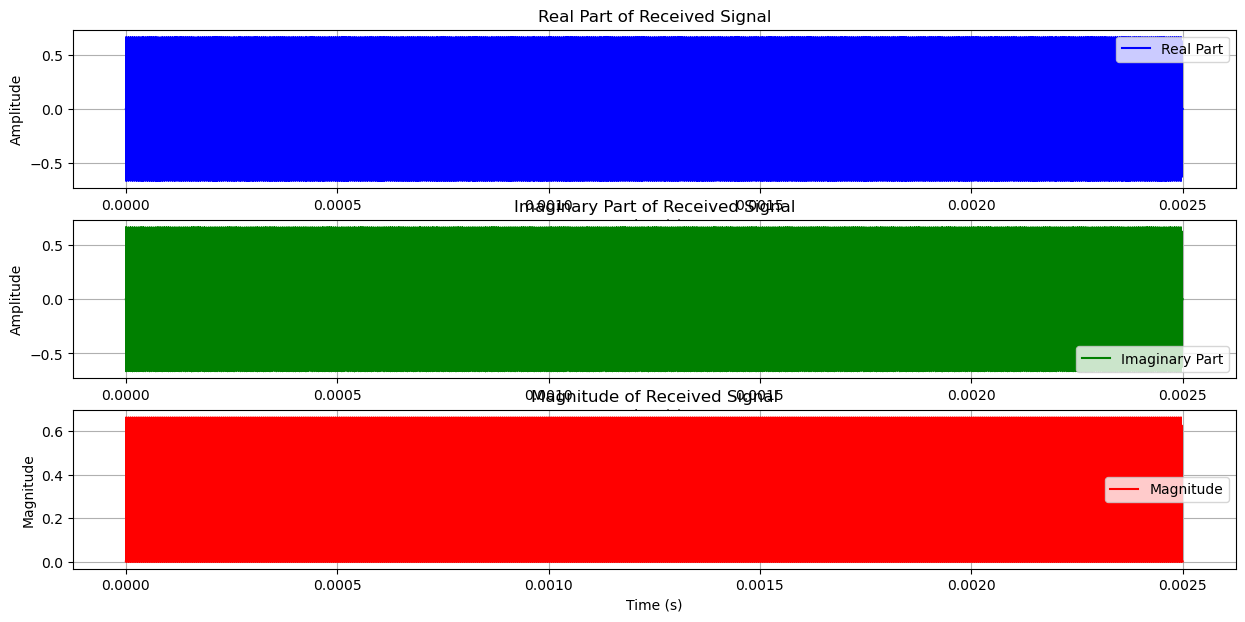

In [15]:
print(num_targets, 'targets')
plt.figure(figsize=(15, 7))

# Plot the real part of the received signal
plt.subplot(3, 1, 1)
plt.plot(t, np.real(received_signal), label='Real Part', color='b')
plt.title('Real Part of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Plot the imaginary part of the received signal
plt.subplot(3, 1, 2)
plt.plot(t, np.imag(received_signal), label='Imaginary Part', color='g')
plt.title('Imaginary Part of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Plot the magnitude of the received signal
plt.subplot(3, 1, 3)
plt.plot(t, np.abs(received_signal), label='Magnitude', color='r')
plt.title('Magnitude of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

## 4. Processing
---

In order to make our simulation closer to reality, and to gain what we really need, which is a range-Doppler map, 

we have to process the signal in the following manner:

1. add noise
2. IQ maps
3. matched filter
4. FFT (Fast Fourier Transform)

### Adding noise

In real world systems, we have noise in our recieved signal. Some from clutter, system noise or thermal noise.

if we want to create a reasonable radar simulation, we must add noise - we choose white gaussian noise for now, for simplicity.

In [16]:
noise_level = 1
noise = noise_level * (np.random.randn(*received_signal.shape) + 1j * np.random.randn(*received_signal.shape))
noisy_signal = received_signal + noise

2 targets


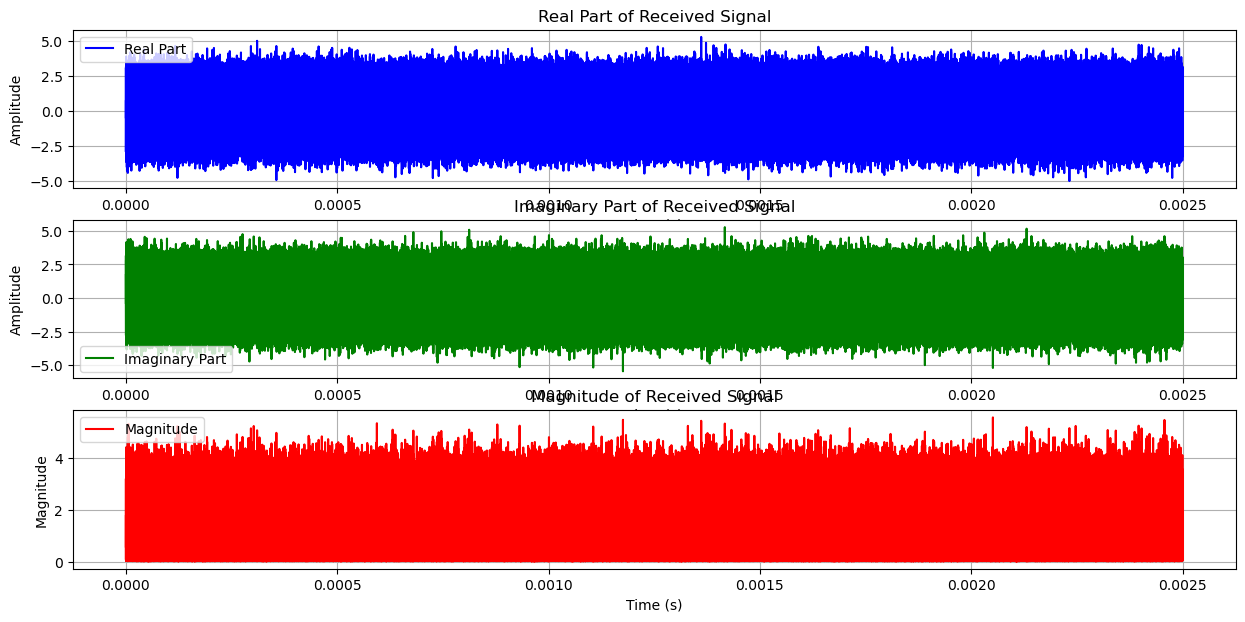

In [17]:
print(num_targets, 'targets')
plt.figure(figsize=(15, 7))

# Plot the real part of the received signal
plt.subplot(3, 1, 1)
plt.plot(t, np.real(noisy_signal), label='Real Part', color='b')
plt.title('Real Part of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Plot the imaginary part of the received signal
plt.subplot(3, 1, 2)
plt.plot(t, np.imag(noisy_signal), label='Imaginary Part', color='g')
plt.title('Imaginary Part of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Plot the magnitude of the received signal
plt.subplot(3, 1, 3)
plt.plot(t, np.abs(noisy_signal), label='Magnitude', color='r')
plt.title('Magnitude of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

### IQ maps

the IQ maps are the raw radar data, before processing. In the DAFC research we use that and not RD maps.

In [18]:
samples_per_pulse = int(PRI * fs)
total_samples = samples_per_pulse * num_pulses
print(total_samples)

if len(noisy_signal) < total_samples:
    IQ_signal = np.pad(noisy_signal, (0, total_samples - len(noisy_signal)), 'constant', constant_values=(0, 0))
elif len(noisy_signal) > total_samples:
    IQ_signal = noisy_signal[:total_samples]

iq_matrix = np.reshape(IQ_signal, (num_pulses, samples_per_pulse))

5000000


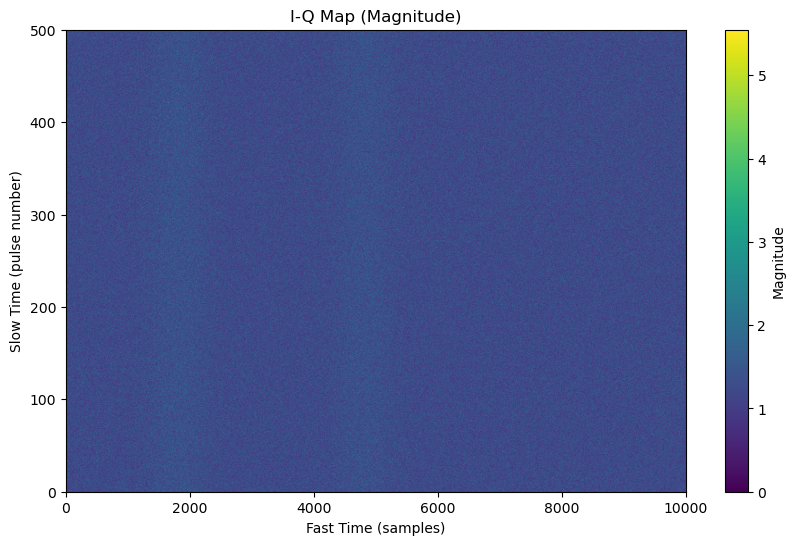

In [19]:
# Calculate the magnitude of the noisy signal matrix
iq_magnitude = np.abs(np.reshape(IQ_signal, (num_pulses, samples_per_pulse)))

# Plot the single I-Q magnitude map
plt.figure(figsize=(10, 6))
plt.imshow(iq_magnitude, aspect='auto', extent=[0, samples_per_pulse, 0, num_pulses], cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('I-Q Map (Magnitude)')
plt.xlabel('Fast Time (samples)')
plt.ylabel('Slow Time (pulse number)')
plt.show()


### Matched Filter

a matched filter is a filter that returns the correllation between the pulse sent and the signal that was recieved.

it works well because where there is only noise, it will not correlate, and the returning target signal will, even if to us it looks like noise, this way we can know where the signal is!


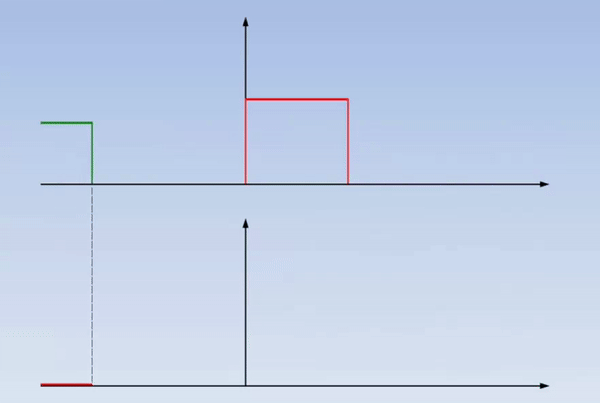

In [20]:
# 2 ways for the same thing...
matched_filter = np.conj(np.flip(chirp_signal[:window_length])) 
processed_signal_conv = np.convolve(noisy_signal, matched_filter, mode='same')
processed_signal_xcorr = correlate(noisy_signal, chirp_signal[:window_length], mode='same')

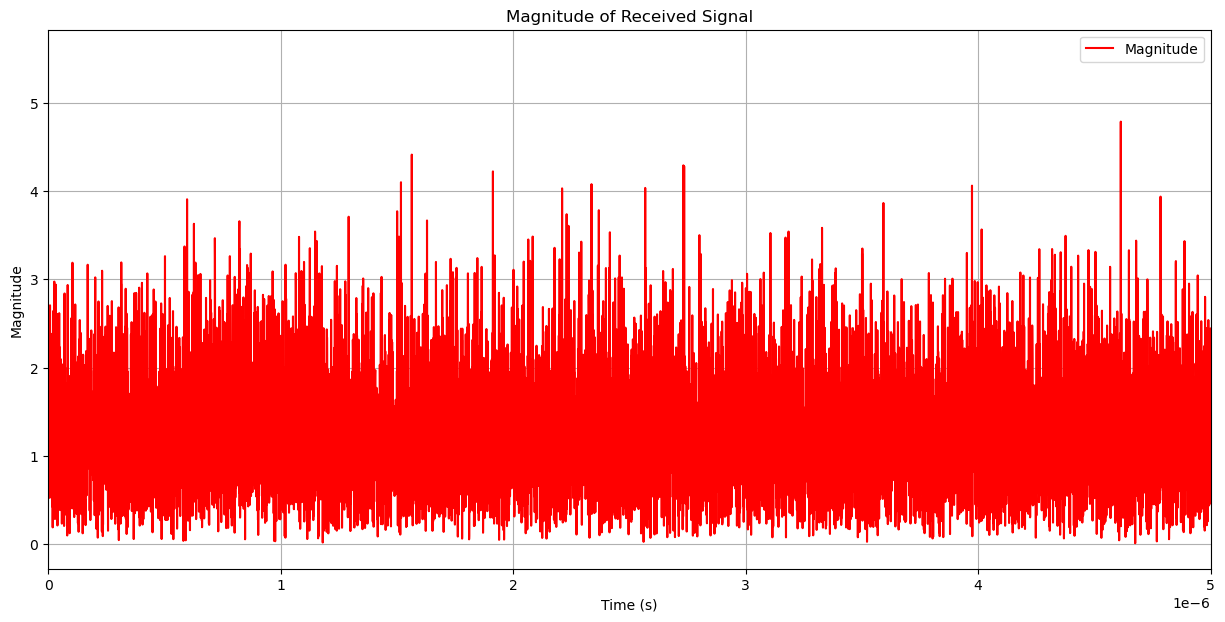

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(t, np.abs(noisy_signal), label='Magnitude', color='r')
plt.title('Magnitude of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.xlim(0,PRI)
plt.grid()
plt.legend()

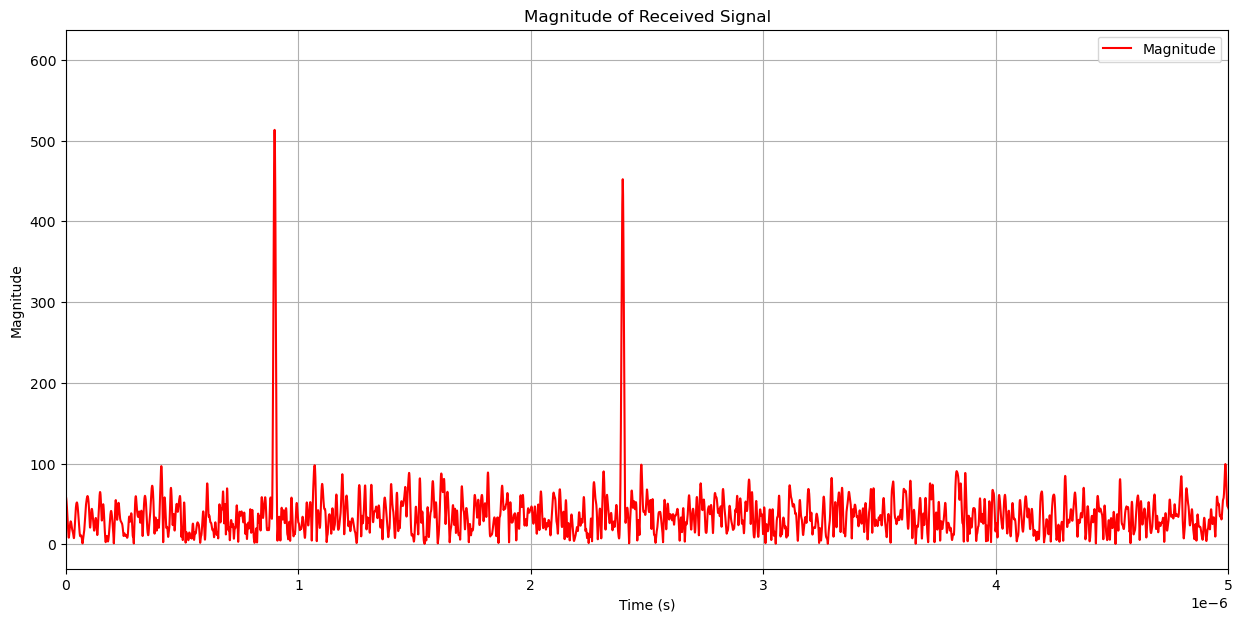

In [22]:
plt.figure(figsize=(15, 7))
plt.plot(t, np.abs(processed_signal_xcorr), label='Magnitude', color='r')
plt.title('Magnitude of Received Signal')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.xlim(0,PRI)
plt.grid()
plt.legend()

### Reshape the signal into a matrix, align the time axis with the matched filter delay

In [23]:
samples_per_pulse = int(PRI * fs)
total_samples = samples_per_pulse * num_pulses


Ensure the processed_signal_conv length matches total_samples


In [24]:
if len(processed_signal_conv) < total_samples:
    processed_signal_conv = np.pad(processed_signal_conv, (0, total_samples - len(processed_signal_conv)), 'constant', constant_values=(0, 0))
elif len(processed_signal_conv) > total_samples:
    processed_signal_conv = processed_signal_conv[:total_samples]


reshape to a 2D matrix where each row represents a pulse and each column represents a sample within that pulse

In [25]:
signal_matrix = np.reshape(processed_signal_conv, (num_pulses, samples_per_pulse))

In [26]:
signal_matrix.shape

(500, 10000)

calculate the matched filter delay so we can align the signal

In [27]:
matched_filter_delay = (window_length - 1) / (2 * fs)  

time axis for a single pulse and subtract the delay, then check the valid time indices

In [28]:
time_axis = np.arange(samples_per_pulse) / fs
adjusted_time_array = time_axis - matched_filter_delay
valid_indices = adjusted_time_array >= 0
adjusted_time_array = adjusted_time_array[valid_indices]
new_signal_matrix = signal_matrix[:, valid_indices]

return to distance, opposite then findind how much time it takes to reach a target and return.

In [29]:
distance = adjusted_time_array * c / 2

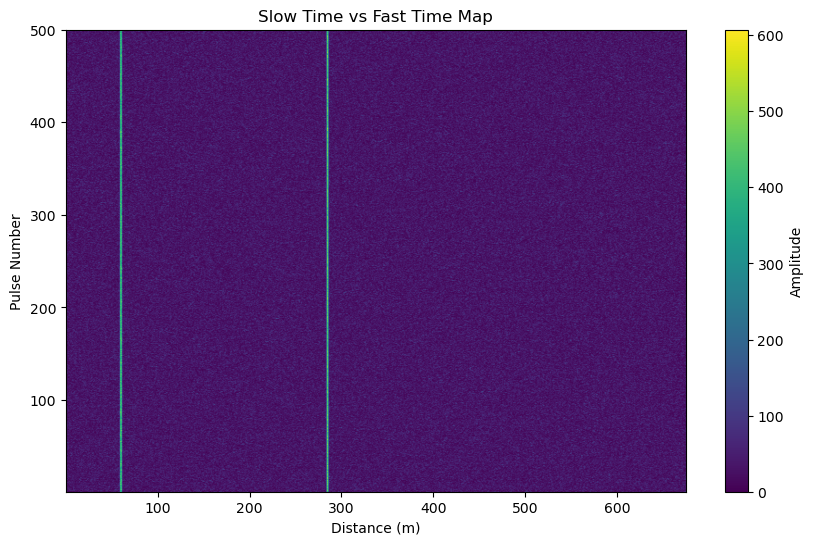

(500, 9000)


In [30]:
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(new_signal_matrix), aspect='auto',
           extent=[distance[0], distance[-1], num_pulses, 1], cmap='viridis')
plt.title('Slow Time vs Fast Time Map')
plt.xlabel('Distance (m)')
plt.ylabel('Pulse Number')
plt.colorbar(label='Amplitude')
plt.gca().invert_yaxis()
plt.show()
print(new_signal_matrix.shape)

### Extract velocity information, perform fft and plot the RD map.

In [31]:
window_slow_time = np.hanning(num_pulses).reshape(-1, 1)
windowed_signal = new_signal_matrix * window_slow_time
fft_result = np.fft.fftshift(np.fft.fft(windowed_signal, axis=0), axes=0)
fd = np.fft.fftfreq(num_pulses, d=PRI)
fd = np.fft.fftshift(fd)
velocity = fd * c / (2 * fc)

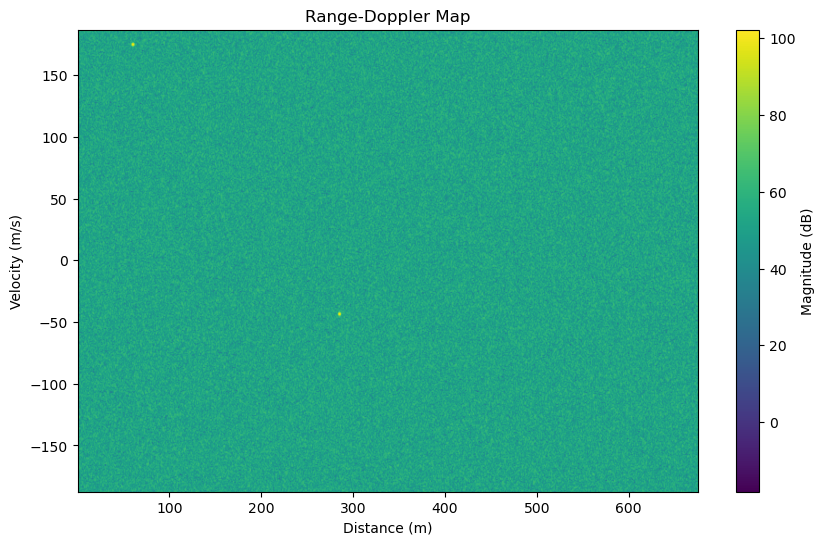

2 targets detected:

Target 1:
  Range: 284.27 meters
  Velocity: -42.98 m/s
  RCS: 0.63 m^2
  Time Delay: 1.895155e-06 seconds
  Doppler Shift: 22922.07 Hz

Target 2:
  Range: 59.66 meters
  Velocity: 175.36 m/s
  RCS: 0.66 m^2
  Time Delay: 3.977094e-07 seconds
  Doppler Shift: -93522.82 Hz



In [32]:
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(fft_result)), aspect='auto',
           extent=[distance[0], distance[-1], velocity[0], velocity[-1]], cmap='viridis')
plt.title('Range-Doppler Map')
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Magnitude (dB)')
plt.show()

print(f"{num_targets} targets detected:\n")
for i in range(num_targets):
    print(f"Target {i+1}:")
    print(f"  Range: {target_ranges[i]:.2f} meters")
    print(f"  Velocity: {target_velocities[i]:.2f} m/s")
    print(f"  RCS: {target_rcs[i]:.2f} m^2")
    print(f"  Time Delay: {time_delays[i]:.6e} seconds")
    print(f"  Doppler Shift: {doppler_shifts[i]:.2f} Hz\n")

## 5. Interactive example
---

In [33]:
def radar_simulation(
    fc_GHz=3.0,                   # Carrier frequency in GHz
    pulse_width_us=1.0,           # Pulse width in microseconds
    B_MHz=50.0,                   # Bandwidth in MHz
    num_pulses=500,               # Number of pulses
    num_targets=2,                # Number of targets
    PRI_factor=10.0,              # PRI is PRI_factor times pulse_width
    fs_factor=10.0,               # Sampling frequency is fs_factor times bandwidth
    noise_level=4,                # Noise level
    plot_transmitted_signal=False,
    plot_first_pulse=False,
    plot_received_signal=False,
    plot_noisy_signal=False,
    plot_slow_time_fast_time_map=False,
    plot_range_doppler_map=True
):
    # Convert inputs to SI units
    fc = fc_GHz * 1e9                    # Convert GHz to Hz
    pulse_width = pulse_width_us * 1e-6  # Convert microseconds to seconds
    B = B_MHz * 1e6                      # Convert MHz to Hz

    # Compute PRI and fs using the provided factors
    PRI = PRI_factor * pulse_width       # Pulse Repetition Interval
    fs = fs_factor * B                   # Sampling frequency

    # Radar parameters
    A = 1                                # Amplitude of the chirp signal
    c = 3e8                              # Speed of light in m/s

    tot_time = num_pulses * PRI          # Total time of the simulation
    window_length = int(pulse_width * fs)  # Number of samples in the pulse

    # Create time vector
    t = np.arange(0, tot_time, 1/fs)
    chirp_signal = np.zeros_like(t, dtype=np.complex128)
    slope = B / pulse_width              # Chirp rate

    # Generate the chirp signal for each pulse
    for i in range(num_pulses):
        pulse_start = i * PRI
        pulse_end = pulse_start + pulse_width
        pulse_indices = (t >= pulse_start) & (t < pulse_end)
        current_window_length = np.sum(pulse_indices)
        hamming_window = np.hamming(current_window_length)

        t_pulse = t[pulse_indices] - pulse_start
        chirp = A * np.exp(1j * 2 * np.pi * (0.5 * slope * t_pulse**2))
        chirp_windowed = chirp * hamming_window
        chirp_signal[pulse_indices] = chirp_windowed

    PRF = 1 / PRI
    v_max = (c * PRF) / (4 * fc)
    max_range = c * (PRI - pulse_width) / 2
    print(f'With the PRI: {np.round(PRI_factor)} * pulse width and pulse width: {np.round(pulse_width_us)} µs, the maximum range is {np.round(max_range)} meters and the maximum velocity is {np.round(v_max)} m/s.')
    
    # Plot the full transmitted chirp signal
    if plot_transmitted_signal:
        plt.figure(figsize=(12, 4))
        plt.plot(t, chirp_signal.real)
        plt.title("Transmitted Chirp Signal")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (Real Part)")
        plt.grid(True)
        plt.show()

    # Plot the first pulse only
    if plot_first_pulse:
        plt.figure(figsize=(12, 4))
        plt.plot(t_pulse, chirp_signal[pulse_indices].real)
        plt.title("Single Chirp Pulse")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (Real Part)")
        plt.grid(True)
        plt.show()

    # Generate random targets within maximum range
    target_ranges = np.random.uniform(0, max_range, num_targets)
    target_velocities = np.random.uniform(-v_max, v_max, num_targets)
    target_rcs = np.random.uniform(0.5, 1, num_targets)
    time_delays = 2 * target_ranges / c
    doppler_shifts = -2 * target_velocities * fc / c

    # Generate received signal with correct time delays relative to pulse start times
    received_signal = np.zeros_like(chirp_signal, dtype=np.complex128)

    for i in range(num_pulses):
        pulse_start = i * PRI
        pulse_end = pulse_start + pulse_width

        for j in range(num_targets):
            # Calculate the total time delay
            total_time_delay = pulse_start + time_delays[j]
            # Time vector for the delayed signal
            t_delayed = t - total_time_delay
            # Find indices where the delayed signal overlaps with the observation window
            valid_indices = (t >= total_time_delay) & (t < total_time_delay + pulse_width)
            t_valid = t_delayed[valid_indices]
            if len(t_valid) == 0:
                continue
            # Generate the delayed chirp
            chirp_delayed = A * np.exp(1j * 2 * np.pi * (0.5 * slope * t_valid**2))
            # Apply the Doppler shift
            doppler_phase = 2 * np.pi * doppler_shifts[j] * t[valid_indices]
            chirp_delayed *= np.exp(1j * doppler_phase)
            # Apply windowing (optional)
            hamming_window = np.hamming(len(chirp_delayed))
            chirp_delayed *= hamming_window
            # Add to the received signal
            received_signal[valid_indices] += target_rcs[j] * chirp_delayed

    # Add noise
    noise = noise_level * (np.random.randn(*received_signal.shape) + 1j * np.random.randn(*received_signal.shape))
    noisy_signal = received_signal + noise

    # Plot the received signal before adding noise
    if plot_received_signal:
        plt.figure(figsize=(15, 7))

        plt.subplot(3, 1, 1)
        plt.plot(t, np.real(received_signal), label='Real Part', color='b')
        plt.title('Real Part of Received Signal (Without Noise)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(t, np.imag(received_signal), label='Imaginary Part', color='g')
        plt.title('Imaginary Part of Received Signal (Without Noise)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(t, np.abs(received_signal), label='Magnitude', color='r')
        plt.title('Magnitude of Received Signal (Without Noise)')
        plt.xlabel('Time (s)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Plot the noisy received signal
    if plot_noisy_signal:
        plt.figure(figsize=(15, 7))

        plt.subplot(3, 1, 1)
        plt.plot(t, np.real(noisy_signal), label='Real Part', color='b')
        plt.title('Real Part of Noisy Received Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(t, np.imag(noisy_signal), label='Imaginary Part', color='g')
        plt.title('Imaginary Part of Noisy Received Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(t, np.abs(noisy_signal), label='Magnitude', color='r')
        plt.title('Magnitude of Noisy Received Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Magnitude')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Matched filtering
    matched_filter = np.conj(np.flip(chirp_signal[:window_length]))
    processed_signal_conv = np.convolve(noisy_signal, matched_filter, mode='same')

    # Reshape signal into pulses
    samples_per_pulse = int(PRI * fs)
    total_samples = samples_per_pulse * num_pulses

    # Ensure the processed_signal_conv length matches total_samples
    if len(processed_signal_conv) < total_samples:
        processed_signal_conv = np.pad(processed_signal_conv, (0, total_samples - len(processed_signal_conv)), 'constant', constant_values=(0, 0))
    elif len(processed_signal_conv) > total_samples:
        processed_signal_conv = processed_signal_conv[:total_samples]

    signal_matrix = np.reshape(processed_signal_conv, (num_pulses, samples_per_pulse))

    # Corrected matched filter delay
    matched_filter_delay = (window_length - 1) / (2 * fs)  # Correct delay in seconds

    # Calculate time axis for range estimation
    time_axis = np.arange(samples_per_pulse) / fs
    # Adjust time axis to account for the matched filter delay
    adjusted_time_array = time_axis - matched_filter_delay
    # Only consider non-negative distances
    valid_indices = adjusted_time_array >= 0
    adjusted_time_array = adjusted_time_array[valid_indices]
    new_signal_matrix = signal_matrix[:, valid_indices]
    distance = adjusted_time_array * c / 2

    # Check if new_signal_matrix is empty
    if new_signal_matrix.size == 0:
        print("Warning: No valid data after adjusting for matched filter delay.")
        return

    # Plot Slow Time vs Fast Time Map
    if plot_slow_time_fast_time_map:
        plt.figure(figsize=(10, 6))
        plt.imshow(np.abs(new_signal_matrix), aspect='auto',
                   extent=[distance[0], distance[-1], num_pulses, 1], cmap='viridis')
        plt.title('Slow Time vs Fast Time Map')
        plt.xlabel('Distance (m)')
        plt.ylabel('Pulse Number')
        plt.colorbar(label='Amplitude')
        plt.gca().invert_yaxis()
        plt.show()

    # Compute FFT and Range-Doppler Map
    window_slow_time = np.hanning(num_pulses).reshape(-1, 1)
    windowed_signal = new_signal_matrix * window_slow_time
    fft_result = np.fft.fftshift(np.fft.fft(windowed_signal, axis=0), axes=0)
    fd = np.fft.fftfreq(num_pulses, d=PRI)
    fd = np.fft.fftshift(fd)
    velocity = fd * c / (2 * fc)
    print(fft_result.shape)

    if plot_range_doppler_map:
        plt.figure(figsize=(10, 6))
        plt.imshow(20 * np.log10(np.abs(fft_result)), aspect='auto',
                   extent=[distance[0], distance[-1], velocity[0], velocity[-1]], cmap='viridis')
        plt.title('Range-Doppler Map')
        plt.xlabel('Distance (m)')
        plt.ylabel('Velocity (m/s)')
        plt.colorbar(label='Magnitude (dB)')
        plt.show()

    # Print target information
    print(f"{num_targets} targets detected:\n")
    for i in range(num_targets):
        print(f"Target {i+1}:")
        print(f"  Range: {target_ranges[i]:.2f} meters")
        print(f"  Velocity: {target_velocities[i]:.2f} m/s")
        print(f"  RCS: {target_rcs[i]:.2f} m^2")
        print(f"  Time Delay: {time_delays[i]:.6e} seconds")
        print(f"  Doppler Shift: {doppler_shifts[i]:.2f} Hz\n")

# Create interactive controls with adjusted layout and style
style = {'description_width': 'initial'}
layout = widgets.Layout(width='500px')

# Plot control checkboxes
plot_controls = widgets.VBox([
    widgets.Checkbox(value=False, description='Plot Transmitted Signal', style=style),
    widgets.Checkbox(value=True, description='Plot First Pulse', style=style),
    widgets.Checkbox(value=False, description='Plot Received Signal', style=style),
    widgets.Checkbox(value=False, description='Plot Noisy Signal', style=style),
    widgets.Checkbox(value=True, description='Plot Slow Time vs Fast Time Map', style=style),
    widgets.Checkbox(value=True, description='Plot Range-Doppler Map', style=style)
])

def interactive_radar_simulation(
    fc_GHz, pulse_width_us, B_MHz, num_pulses, num_targets, PRI_factor, fs_factor, noise_level,
    plot_transmitted_signal_checkbox,
    plot_first_pulse_checkbox,
    plot_received_signal_checkbox,
    plot_noisy_signal_checkbox,
    plot_slow_time_fast_time_map_checkbox,
    plot_range_doppler_map_checkbox
):
    radar_simulation(
        fc_GHz=fc_GHz,
        pulse_width_us=pulse_width_us,
        B_MHz=B_MHz,
        num_pulses=num_pulses,
        num_targets=num_targets,
        PRI_factor=PRI_factor,
        fs_factor=fs_factor,
        noise_level=noise_level,
        plot_transmitted_signal=plot_transmitted_signal_checkbox,
        plot_first_pulse=plot_first_pulse_checkbox,
        plot_received_signal=plot_received_signal_checkbox,
        plot_noisy_signal=plot_noisy_signal_checkbox,
        plot_slow_time_fast_time_map=plot_slow_time_fast_time_map_checkbox,
        plot_range_doppler_map=plot_range_doppler_map_checkbox
    )

interact(
    interactive_radar_simulation,
    fc_GHz=widgets.FloatSlider(min=0.5, max=80, step=0.1, value=80.0,
                               description='Carrier Frequency (GHz)', style=style, layout=layout),
    pulse_width_us=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0,
                                       description='Pulse Width (µs)', style=style, layout=layout),
    B_MHz=widgets.FloatSlider(min=1.0, max=200.0, step=1.0, value=50.0,
                              description='Bandwidth (MHz)', style=style, layout=layout),
    num_pulses=widgets.IntSlider(min=5, max=1000, step=10, value=500,
                                 description='Number of Pulses', style=style, layout=layout),
    num_targets=widgets.IntSlider(min=1, max=8, step=1, value=4,
                                  description='Number of Targets', style=style, layout=layout),
    PRI_factor=widgets.FloatSlider(min=1.0, max=40.0, step=1, value=5.0,
                                   description='PRI Factor', style=style, layout=layout),
    fs_factor=widgets.FloatSlider(min=2.0, max=20.0, step=1.0, value=10.0,
                                  description='Sampling Frequency Factor', style=style, layout=layout),
    noise_level=widgets.FloatSlider(min=0, max=10, step=0.5, value=4,
                                    description='Noise Level', style=style, layout=layout),
    plot_transmitted_signal_checkbox=plot_controls.children[0],
    plot_first_pulse_checkbox=plot_controls.children[1],
    plot_received_signal_checkbox=plot_controls.children[2],
    plot_noisy_signal_checkbox=plot_controls.children[3],
    plot_slow_time_fast_time_map_checkbox=plot_controls.children[4],
    plot_range_doppler_map_checkbox=plot_controls.children[5]
);


interactive(children=(FloatSlider(value=80.0, description='Carrier Frequency (GHz)', layout=Layout(width='500p…

## 6. Dataset creation
---

### functions for generating the RD maps from scratch (the simulation without the visualization)

create and save data to create the dataset.

In [34]:
def radar_simulation(
    fc_GHz=80.0,                   # Carrier frequency in GHz
    pulse_width_us=1.0,           # Pulse width in microseconds
    B_MHz=50.0,                   # Bandwidth in MHz
    num_pulses=250,               # Number of pulses
    num_targets=2,                # Number of targets
    PRI_factor=5.0,              # PRI is PRI_factor times pulse_width
    fs_factor=5.0,               # Sampling frequency is fs_factor times bandwidth
    noise_level=1                 # Noise level
):
    # Import necessary libraries
    import numpy as np
    
    # Convert inputs to SI units
    fc = fc_GHz * 1e9                    # Convert GHz to Hz
    pulse_width = pulse_width_us * 1e-6  # Convert microseconds to seconds
    B = B_MHz * 1e6                      # Convert MHz to Hz

    # Compute PRI and fs using the provided factors
    PRI = PRI_factor * pulse_width       # Pulse Repetition Interval
    fs = fs_factor * B                   # Sampling frequency

    # Radar parameters
    A = 1                                # Amplitude of the chirp signal
    c = 3e8                              # Speed of light in m/s

    tot_time = num_pulses * PRI          # Total time of the simulation
    window_length = int(pulse_width * fs)  # Number of samples in the pulse

    # Create time vector
    t = np.arange(0, tot_time, 1/fs)
    chirp_signal = np.zeros_like(t, dtype=np.complex128)
    slope = B / pulse_width              # Chirp rate

    # Generate the chirp signal for each pulse
    for i in range(num_pulses):
        pulse_start = i * PRI
        pulse_end = pulse_start + pulse_width
        pulse_indices = (t >= pulse_start) & (t < pulse_end)
        current_window_length = np.sum(pulse_indices)
        hamming_window = np.hamming(current_window_length)

        t_pulse = t[pulse_indices] - pulse_start
        chirp = A * np.exp(1j * 2 * np.pi * (0.5 * slope * t_pulse**2))
        chirp_windowed = chirp * hamming_window
        chirp_signal[pulse_indices] = chirp_windowed

    PRF = 1 / PRI
    v_max = (c * PRF) / (4 * fc)
    max_range = c * (PRI - pulse_width) / 2
    
    # Generate random targets within maximum range
    target_ranges = np.random.uniform(0, max_range, num_targets)
    target_velocities = np.random.uniform(-v_max, v_max, num_targets)
    target_rcs = np.random.uniform(0.5, 1, num_targets)
    time_delays = 2 * target_ranges / c
    doppler_shifts = -2 * target_velocities * fc / c

    # Generate received signal with correct time delays relative to pulse start times
    received_signal = np.zeros_like(chirp_signal, dtype=np.complex128)

    for i in range(num_pulses):
        pulse_start = i * PRI
        pulse_end = pulse_start + pulse_width

        for j in range(num_targets):
            # Calculate the total time delay
            total_time_delay = pulse_start + time_delays[j]
            # Time vector for the delayed signal
            t_delayed = t - total_time_delay
            # Find indices where the delayed signal overlaps with the observation window
            valid_indices = (t >= total_time_delay) & (t < total_time_delay + pulse_width)
            t_valid = t_delayed[valid_indices]
            if len(t_valid) == 0:
                continue
            # Generate the delayed chirp
            chirp_delayed = A * np.exp(1j * 2 * np.pi * (0.5 * slope * t_valid**2))
            # Apply the Doppler shift
            doppler_phase = 2 * np.pi * doppler_shifts[j] * t[valid_indices]
            chirp_delayed *= np.exp(1j * doppler_phase)
            # Apply windowing (optional)
            hamming_window = np.hamming(len(chirp_delayed))
            chirp_delayed *= hamming_window
            # Add to the received signal
            received_signal[valid_indices] += target_rcs[j] * chirp_delayed

    # Add noise
    noise = noise_level * (np.random.randn(*received_signal.shape) + 1j * np.random.randn(*received_signal.shape))
    noisy_signal = received_signal + noise

    # IQ signal map
    samples_per_pulse = int(PRI * fs)
    total_samples = samples_per_pulse * num_pulses

    IQ_signal = np.pad(noisy_signal, (0, total_samples - len(noisy_signal)), 'constant', constant_values=(0, 0))
    if len(noisy_signal) < total_samples:
        IQ_signal = np.pad(noisy_signal, (0, total_samples - len(noisy_signal)), 'constant', constant_values=(0, 0))
    elif len(noisy_signal) > total_samples:
        IQ_signal = noisy_signal[:total_samples]
    
    iq_matrix = np.reshape(IQ_signal, (num_pulses, samples_per_pulse))
    iq_magnitude = np.abs(np.reshape(IQ_signal, (num_pulses, samples_per_pulse)))

    # Matched filtering
    matched_filter = np.conj(np.flip(chirp_signal[:window_length]))
    processed_signal_conv = np.convolve(noisy_signal, matched_filter, mode='same')

    # Reshape signal into pulses
    samples_per_pulse = int(PRI * fs)
    total_samples = samples_per_pulse * num_pulses

    # Ensure the processed_signal_conv length matches total_samples
    if len(processed_signal_conv) < total_samples:
        processed_signal_conv = np.pad(processed_signal_conv, (0, total_samples - len(processed_signal_conv)), 'constant', constant_values=(0, 0))
    elif len(processed_signal_conv) > total_samples:
        processed_signal_conv = processed_signal_conv[:total_samples]

    signal_matrix = np.reshape(processed_signal_conv, (num_pulses, samples_per_pulse))

    # Corrected matched filter delay
    matched_filter_delay = (window_length - 1) / (2 * fs)  # Correct delay in seconds

    # Calculate time axis for range estimation
    time_axis = np.arange(samples_per_pulse) / fs
    # Adjust time axis to account for the matched filter delay
    adjusted_time_array = time_axis - matched_filter_delay
    # Only consider non-negative distances
    valid_indices = adjusted_time_array >= 0
    adjusted_time_array = adjusted_time_array[valid_indices]
    new_signal_matrix = signal_matrix[:, valid_indices]
    iq_matrix = iq_matrix[:, valid_indices]
    distance = adjusted_time_array * c / 2

    # Check if new_signal_matrix is empty
    if new_signal_matrix.size == 0:
        return None, None, None, None, None

    # Compute FFT and Range-Doppler Map
    window_slow_time = np.hanning(num_pulses).reshape(-1, 1)
    windowed_signal = new_signal_matrix * window_slow_time
    fft_result = np.fft.fftshift(np.fft.fft(windowed_signal, axis=0), axes=0)
    fd = np.fft.fftfreq(num_pulses, d=PRI)
    fd = np.fft.fftshift(fd)
    velocity = fd * c / (2 * fc)

    # Return the range-Doppler map and target locations
    return fft_result, iq_matrix, distance, velocity, target_ranges, target_velocities

def generate_radar_dataset(num_samples):
    dataset = []
    for _ in range(num_samples):
        num_targets = np.random.randint(1, 9)  # Random number of targets between 1 and 8
        result = radar_simulation(num_targets=num_targets)
        fft_result,iq_matrix, distance, velocity, target_ranges, target_velocities = result
        if fft_result is None:
            continue  # Skip if no valid data
        sample = {
            'range_doppler_map': fft_result,
            'IQ_map': iq_matrix,
            'distance_axis': distance,
            'velocity_axis': velocity,
            'target_ranges': target_ranges,
            'target_velocities': target_velocities
        }
        dataset.append(sample)
    return dataset


In [35]:
dataset = generate_radar_dataset(1)

Range-Doppler Map shape: (250, 1125)
IQ Map shape: (250, 1125)
Distance axis length: 1125
Velocity axis length: 250
Target ranges: [241.33038805 463.44248201 219.14254743 512.98825785  75.39760528]
Target velocities: [ 181.91259843 -127.49086116  110.87781947 -133.26807738  -26.65758942]


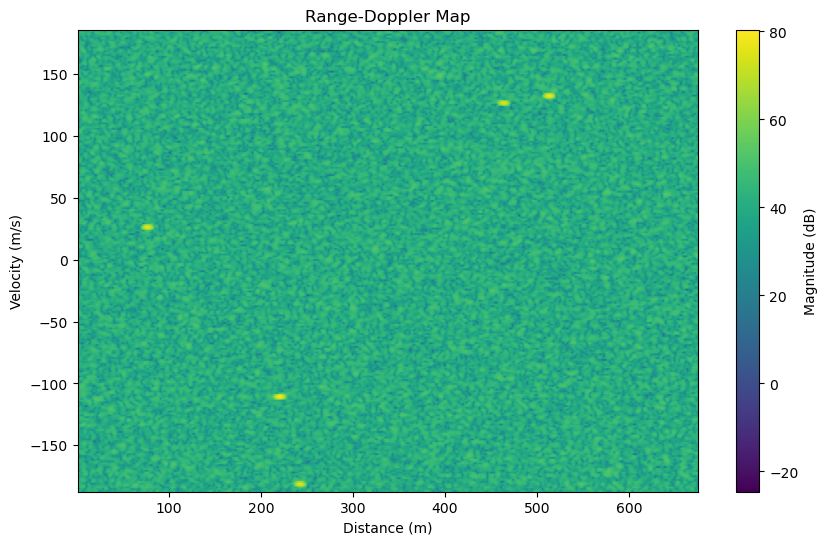

In [36]:
first_sample = dataset[0]
range_doppler_map = first_sample['range_doppler_map']
IQ_map = first_sample['IQ_map']
distance_axis = first_sample['distance_axis']
velocity_axis = first_sample['velocity_axis']
target_ranges = first_sample['target_ranges']
target_velocities = first_sample['target_velocities']

print("Range-Doppler Map shape:", range_doppler_map.shape)
print("IQ Map shape:", IQ_map.shape)
print("Distance axis length:", len(distance_axis))
print("Velocity axis length:", len(velocity_axis))
print("Target ranges:", target_ranges)
print("Target velocities:", target_velocities)


plt.figure(figsize=(10, 6))
extent = [distance_axis[0], distance_axis[-1], velocity_axis[0], velocity_axis[-1]]
plt.imshow(20 * np.log10(np.abs(range_doppler_map)), aspect='auto', extent=extent, cmap='viridis', origin='lower')
plt.title('Range-Doppler Map')
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.colorbar(label='Magnitude (dB)')

# Overlay the true target positions
#for r, v in zip(target_ranges, target_velocities):
    # Plot the red 'x' at the corresponding position
#    print(r,-v)
#    plt.plot(r, -v, 'rx', markersize=10, markeredgewidth=2)

plt.show()

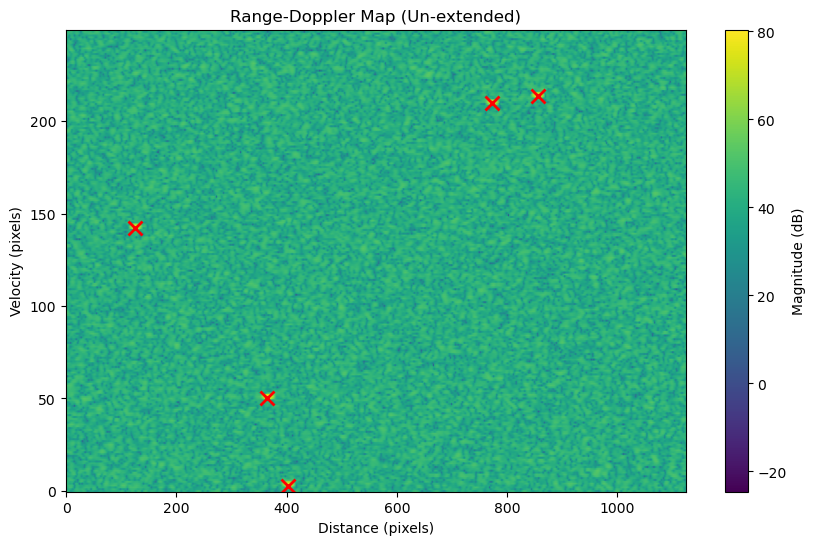

In [37]:
# Define the physical ranges
distance_min = distance_axis[0]      # 0.0375 m
distance_max = distance_axis[-1]     # 674.9625 m
velocity_min = velocity_axis[0]      # -187.5 m/s
velocity_max = velocity_axis[-1]     # 186.75 m/s

# Get the number of pixels in each dimension
num_distance = range_doppler_map.shape[1]  # 9000 pixels
num_velocity = range_doppler_map.shape[0]  # 500 pixels

# Calculate the scale (meters per pixel and m/s per pixel)
distance_per_pixel = (distance_max - distance_min) / num_distance
velocity_per_pixel = (velocity_max - velocity_min) / num_velocity

# Convert target lists to numpy arrays for vectorized operations
target_ranges = np.array(target_ranges)       # e.g., [302.60025595]
target_velocities = np.array(target_velocities)  # e.g., [102.14196667]

# Calculate pixel indices
x_pixels = (target_ranges - distance_min) / distance_per_pixel
y_pixels = (target_velocities - velocity_min) / velocity_per_pixel

plt.figure(figsize=(10, 6))
plt.imshow(
    20 * np.log10(np.abs(range_doppler_map)),
    aspect='auto',
    cmap='viridis',
    origin='lower'
)
plt.title('Range-Doppler Map (Un-extended)')
plt.xlabel('Distance (pixels)')
plt.ylabel('Velocity (pixels)')
plt.colorbar(label='Magnitude (dB)')

# Overlay the target positions
for x, y in zip(x_pixels, y_pixels):
    plt.plot(x, -y+250, 'rx', markersize=10, markeredgewidth=2)

plt.show()


### create and save the dataset

In [38]:
SAVE_DIRECTORY = '/home/hawk/Desktop/TestRadarDataset'
os.makedirs(SAVE_DIRECTORY, exist_ok=True)
print(f"Saving samples to directory: {SAVE_DIRECTORY}")

NUM_SAMPLES = 1000

for i in range(0, NUM_SAMPLES + 1):
    num_targets = np.random.randint(1, 9)
    
    result = radar_simulation(num_targets=num_targets)
    
    # Check if the simulation returned valid data
    if result is None:
        print(f"Sample {i}: No valid data, skipping.")
        continue  # Skip to the next iteration if no data
    
    fft_result, IQ_map, distance, velocity, target_ranges, target_velocities = result
    sample = {
        'range_doppler_map': fft_result,
        'IQ_map': IQ_map,
        'distance_axis': distance,
        'velocity_axis': velocity,
        'target_ranges': target_ranges,
        'target_velocities': target_velocities
    }
    
    filename = os.path.join(SAVE_DIRECTORY, f'sample_{i:05d}.pkl')
    
    try:
        with open(filename, 'wb') as f:
            pickle.dump(sample, f)
        print(f"Saved sample {i} to {filename}")
    except Exception as e:
        print(f"Error saving sample {i}: {e}")


Saving samples to directory: /home/hawk/Desktop/TestRadarDataset
Saved sample 0 to /home/hawk/Desktop/TestRadarDataset/sample_00000.pkl
Saved sample 1 to /home/hawk/Desktop/TestRadarDataset/sample_00001.pkl
Saved sample 2 to /home/hawk/Desktop/TestRadarDataset/sample_00002.pkl
Saved sample 3 to /home/hawk/Desktop/TestRadarDataset/sample_00003.pkl
Saved sample 4 to /home/hawk/Desktop/TestRadarDataset/sample_00004.pkl
Saved sample 5 to /home/hawk/Desktop/TestRadarDataset/sample_00005.pkl
Saved sample 6 to /home/hawk/Desktop/TestRadarDataset/sample_00006.pkl
Saved sample 7 to /home/hawk/Desktop/TestRadarDataset/sample_00007.pkl
Saved sample 8 to /home/hawk/Desktop/TestRadarDataset/sample_00008.pkl
Saved sample 9 to /home/hawk/Desktop/TestRadarDataset/sample_00009.pkl
Saved sample 10 to /home/hawk/Desktop/TestRadarDataset/sample_00010.pkl
Saved sample 11 to /home/hawk/Desktop/TestRadarDataset/sample_00011.pkl
Saved sample 12 to /home/hawk/Desktop/TestRadarDataset/sample_00012.pkl
Saved sam

## Bonus - Torch dataset
---

In [39]:
class RangeDopplerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Directory with all the .pkl files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
        self.file_list.sort()  # Optional: sort files for consistency

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load the pickle file
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        with open(file_path, 'rb') as f:
            sample = pickle.load(f)

        # Extract data from the sample
        range_doppler_map = sample['range_doppler_map']  # Shape: (velocity, distance)
        IQ_map = sample['IQ_map']
        distance_axis = sample['distance_axis']
        velocity_axis = sample['velocity_axis']
        target_ranges = sample['target_ranges']
        target_velocities = sample['target_velocities']

        # Convert RD map to dB scale, adding epsilon to avoid log(0)
        rd_map_db = 20 * np.log10(np.abs(range_doppler_map) + 1e-6)

        # Normalize RD map to [0, 1]
        rd_map_db = (rd_map_db - rd_map_db.min()) / (rd_map_db.max() - rd_map_db.min())

        # Convert to float32 for PyTorch
        rd_map_db = rd_map_db.astype(np.float32)

        # Prepare RD map tensor with shape (1, velocity, distance)
        rd_map_tensor = torch.from_numpy(rd_map_db).unsqueeze(0)  # Add channel dimension

        # Calculate pixel indices for targets
        distance_min = distance_axis[0]
        distance_max = distance_axis[-1]
        velocity_min = velocity_axis[0]
        velocity_max = velocity_axis[-1]

        num_distance = rd_map_db.shape[1]
        num_velocity = rd_map_db.shape[0]

        distance_per_pixel = (distance_max - distance_min) / num_distance
        velocity_per_pixel = (velocity_max - velocity_min) / num_velocity

        target_ranges = np.array(target_ranges)
        target_velocities = np.array(target_velocities)

        # Compute pixel indices
        x_pixels = ((target_ranges - distance_min) / distance_per_pixel).astype(np.int64)
        y_pixels = ((target_velocities - velocity_min) / velocity_per_pixel).astype(np.int64)

        # Clamp the pixel indices to be within the RD map
        x_pixels = np.clip(x_pixels, 0, num_distance - 1)
        y_pixels = np.clip(y_pixels, 0, num_velocity - 1)

        # Apply y-coordinate transformation: y' = -y + (V - 1)
        y_pixels_transformed = (num_velocity - 1) - y_pixels

        # Create a binary ground truth map
        ground_truth = np.zeros((num_velocity, num_distance), dtype=np.float32)
        ground_truth[y_pixels_transformed, x_pixels] = 1.0  # Mark target positions

        # Convert ground truth to tensor
        ground_truth_tensor = torch.from_numpy(ground_truth)

        sample_dict = {
            'rd_map': rd_map_tensor,               # Tensor shape: (1, V, D)
            'IQ_map': IQ_map,
            'ground_truth': ground_truth_tensor    # Tensor shape: (V, D)
        }

        if self.transform:
            sample_dict = self.transform(sample_dict)

        return sample_dict


In [40]:
def visualize_sample_aligned(sample, zoom_size=20):
    """
    Visualizes the RD map and its corresponding binary ground truth map side by side.
    Ensures that the targets are correctly aligned by applying the y-coordinate transformation.

    Args:
        sample (dict): A dictionary containing 'rd_map' and 'ground_truth' tensors.
        zoom_size (int, optional): The size of the zoom window around each target in pixels.
    """
    rd_map = sample['rd_map'].squeeze(0).numpy()            # Shape: (V, D)
    ground_truth = sample['ground_truth'].numpy()           # Shape: (V, D)

    # Find target positions
    y, x = np.where(ground_truth == 1)

    # Create a figure with two subplots: RD Map and Binary Map
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # ---- Plot 1: RD Map with Overlaid Targets ----
    ax1 = axes[0]
    im1 = ax1.imshow(rd_map, aspect='auto', cmap='viridis', origin='lower')
    ax1.set_title('Range-Doppler Map (dB) with Targets')
    ax1.set_xlabel('Distance (pixels)')
    ax1.set_ylabel('Velocity (pixels)')
    fig.colorbar(im1, ax=ax1, label='Normalized Magnitude')

    # Overlay targets
    #ax1.scatter(x, y, marker='x', color='red', s=100, label='Targets')
    #ax1.legend()

    # ---- Plot 2: Binary Ground Truth Map with Enlarged Markers ----
    ax2 = axes[1]
    im2 = ax2.imshow(ground_truth, aspect='auto', cmap='gray', origin='lower')
    ax2.set_title('Binary Ground Truth Map with Targets')
    ax2.set_xlabel('Distance (pixels)')
    ax2.set_ylabel('Velocity (pixels)')
    fig.colorbar(im2, ax=ax2, label='Target Presence')

    # Overlay enlarged markers on the binary map
    ax2.scatter(x, y, marker='o', facecolors='none', edgecolors='red', s=200, linewidths=2, label='Targets')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # ---- Zoomed-In Views Around Each Target ----
    num_targets = len(x)
    if num_targets == 0:
        print("No targets found in the sample.")
        return

    # Create a separate figure for zoomed-in views
    fig_zoom, axes_zoom = plt.subplots(1, num_targets, figsize=(5 * num_targets, 5))
    if num_targets == 1:
        axes_zoom = [axes_zoom]  # Make it iterable

    for idx, (xi, yi) in enumerate(zip(x, y)):
        # Define zoom window boundaries
        x_start = max(xi - zoom_size, 0)
        x_end = min(xi + zoom_size, ground_truth.shape[1])
        y_start = max(yi - zoom_size, 0)
        y_end = min(yi + zoom_size, ground_truth.shape[0])

        # Extract zoomed-in binary map region
        zoom_binary = ground_truth[y_start:y_end, x_start:x_end]

        ax_zoom = axes_zoom[idx]
        im_zoom = ax_zoom.imshow(zoom_binary, cmap='gray', origin='lower')
        ax_zoom.set_title(f'Zoomed-In Target {idx + 1}')
        ax_zoom.set_xlabel('Distance (pixels)')
        ax_zoom.set_ylabel('Velocity (pixels)')

        # Mark the target position within the zoomed-in window
        target_x = xi - x_start
        target_y = yi - y_start
        ax_zoom.scatter(target_x, target_y, marker='o', facecolors='none', edgecolors='red', s=200, linewidths=2)

        # Optional: Add grid for better visualization
        ax_zoom.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


In [42]:
# # Define the data directory
# data_directory = '/home/hawk/Desktop/MyRadarDataset'

# # Instantiate the dataset
# rd_dataset = RangeDopplerDataset(data_dir=data_directory)

# # Create a DataLoader for batching and shuffling (optional for visualization)
# data_loader = DataLoader(rd_dataset, batch_size=16, shuffle=True, num_workers=4)
# # Get the first sample from the dataset
# sample = rd_dataset[8]

# # Visualize the sample
# visualize_sample_aligned(sample, zoom_size=20)



## Suggestions and future work



Planned future work:
1. finish creating the dataset - check for size reduction
2. train a simple CNN on this data
3. train the DAFC neural network. compare the results with the cnn
4. train a new model, compare with the other results.
5. add the heavy tailed noise, check for performance again.

less samples per chirp (smaller PRI, samller fs)
reduce pulse number.
reduce bandwidth.

compare between the performance of IQ vs RD


Suggestions:
1. check for minimal distance between targets.
2. consider a more realistic scenario.